In [1]:
# UCSD ECE 143 Programming for Data Analysis
# Winter 2023
# Author: m3cheung@ucsd.edu
# Final Project: create mmr by race bar graph for years 2018-2021

Import modules

In [2]:
import pandas as pd
import plotly.express as px
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

Load csv files into Pandas DataFrames

In [3]:
races_deaths_df = pd.read_csv(\
    "../data_csv/races-total_deaths.csv").drop(columns=["Notes", "Single Race 6 Code", "Year Code", "Population", "Crude Rate", "Hispanic Origin Code"])
races_births_df = pd.read_csv(\
    "../data_csv/races-total_births.csv").drop(columns=["Notes", "Mother's Single Race 6 Code", "Year Code", "Mother's Hispanic Origin Code"])

display(races_deaths_df)
display(races_births_df)


,Single Race 6,Hispanic Origin,Year,Deaths
0,American Indian or Alaska Native,Not Hispanic or Latino,2019.0,14.0
1,American Indian or Alaska Native,Not Hispanic or Latino,2020.0,13.0
2,American Indian or Alaska Native,Not Hispanic or Latino,2021.0,31.0
3,Asian,Not Hispanic or Latino,2018.0,32.0
4,Asian,Not Hispanic or Latino,2019.0,33.0
...,...,...,...,...
86,NaN,NaN,NaN,NaN
87,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN


,Mother's Single Race 6,Mother's Hispanic Origin,Year,Births
0,American Indian or Alaska Native,Hispanic or Latino,2018.0,7004.0
1,American Indian or Alaska Native,Hispanic or Latino,2019.0,7522.0
2,American Indian or Alaska Native,Hispanic or Latino,2020.0,7950.0
3,American Indian or Alaska Native,Hispanic or Latino,2021.0,8331.0
4,American Indian or Alaska Native,Hispanic or Latino,NaN,30807.0
...,...,...,...,...
119,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN
121,NaN,NaN,NaN,NaN
122,NaN,NaN,NaN,NaN


Clean up data

In [4]:
# remove NaN rows
races_deaths_df = races_deaths_df.dropna()
races_births_df = races_births_df.dropna()

# rename column so that both sets say "Single Race 6"
races_births_df = races_births_df.rename(columns={"Mother's Single Race 6":"Single Race 6"})
# rename column so that both sets say "Hispanic Origin"
races_births_df = races_births_df.rename(
    columns={"Mother's Hispanic Origin":"Hispanic Origin"})

# THE CODE AFTER THIS IS REALLY BAD, I ONLY FIGURED OUT LATER THAT YOU CAN USE MERGE FOR MULTIPLE COLUMNS HAHA, SO IGNORE THE REST OF THIS CODE, YOU WILL PROBABLY BE ABLE TO FIND A BETTER METHOD THAN THIS
# create new df for the ratio!
ratio_df = races_births_df.merge(races_deaths_df, on="Single Race 6", how="left")

# match years
ratio_df = ratio_df[ratio_df["Year_x"] == ratio_df["Year_y"]]
ratio_df = ratio_df[ratio_df["Hispanic Origin_x"] == ratio_df["Hispanic Origin_y"]]

# isolate hispanic origin rows
hisp_df = ratio_df[ratio_df["Hispanic Origin_x"] == "Hispanic or Latino"]
ratio_df = ratio_df[ratio_df["Hispanic Origin_x"] != "Hispanic or Latino"]

# reset indices to start from 0
ratio_df = ratio_df.reset_index(drop=True)

# add row to include hispanic origin for year 2018
ratio_df.loc[len(ratio_df.index)] = ["Hispanic Origin", "", "2018", hisp_df[hisp_df["Year_x"] == 2018.0]["Births"].sum(), "", "", hisp_df[hisp_df["Year_x"] == 2018.0]["Deaths"].sum()]

# add row to include hispanic origin for year 2019
ratio_df.loc[len(ratio_df.index)] = ["Hispanic Origin", "", "2019", hisp_df[hisp_df["Year_x"] == 2019.0]["Births"].sum(), "", "", hisp_df[hisp_df["Year_x"] == 2019.0]["Deaths"].sum()]

# add row to include hispanic origin for year 2020
ratio_df.loc[len(ratio_df.index)] = ["Hispanic Origin", "", "2020", hisp_df[hisp_df["Year_x"] == 2020.0]["Births"].sum(), "", "", hisp_df[hisp_df["Year_x"] == 2020.0]["Deaths"].sum()]

# add row to include hispanic origin for year 2021
ratio_df.loc[len(ratio_df.index)] = ["Hispanic Origin", "", "2021", hisp_df[hisp_df["Year_x"] == 2021.0]["Births"].sum(), "", "", hisp_df[hisp_df["Year_x"] == 2021.0]["Deaths"].sum()]

# drop all extra columns
ratio_df = ratio_df.drop(columns=["Hispanic Origin_x", "Hispanic Origin_y", "Year_y"])

# Rename Year column
ratio_df = ratio_df.rename(columns={"Year_x":"Year"})

# remove more than one race rows, due to data labeled as "unreliable"
ratio_df = ratio_df.drop(ratio_df[ratio_df["Single Race 6"] == "More than one race"].index, axis=0)
ratio_df = ratio_df.drop(ratio_df[ratio_df["Single Race 6"] == "American Indian or Alaska Native"].index, axis=0)

# consider suppressed rows as 0, since suppressed < 10
ratio_df["Deaths"] = ratio_df["Deaths"].fillna(0)

display(ratio_df)

,Single Race 6,Year,Births,Deaths
3,Asian,2018.0,240798.0,32.0
4,Asian,2019.0,238769.0,33.0
5,Asian,2020.0,219068.0,27.0
6,Asian,2021.0,213813.0,36.0
7,Black or African American,2018.0,552029.0,206.0
8,Black or African American,2019.0,548075.0,241.0
9,Black or African American,2020.0,529811.0,293.0
10,Black or African American,2021.0,517889.0,362.0
11,White,2018.0,1956413.0,291.0
12,White,2019.0,1915912.0,343.0


Calculate MMR for each row

In [5]:
# create column for MMR = (Deaths/Live Births * 100,000)
ratio_df["MMR per 100,000 Live Births"] = round(
    ratio_df["Deaths"] / ratio_df["Births"] * 100000)

display(ratio_df)

,Single Race 6,Year,Births,Deaths,"MMR per 100,000 Live Births"
3,Asian,2018.0,240798.0,32.0,13.0
4,Asian,2019.0,238769.0,33.0,14.0
5,Asian,2020.0,219068.0,27.0,12.0
6,Asian,2021.0,213813.0,36.0,17.0
7,Black or African American,2018.0,552029.0,206.0,37.0
8,Black or African American,2019.0,548075.0,241.0,44.0
9,Black or African American,2020.0,529811.0,293.0,55.0
10,Black or African American,2021.0,517889.0,362.0,70.0
11,White,2018.0,1956413.0,291.0,15.0
12,White,2019.0,1915912.0,343.0,18.0


Create Bar graph

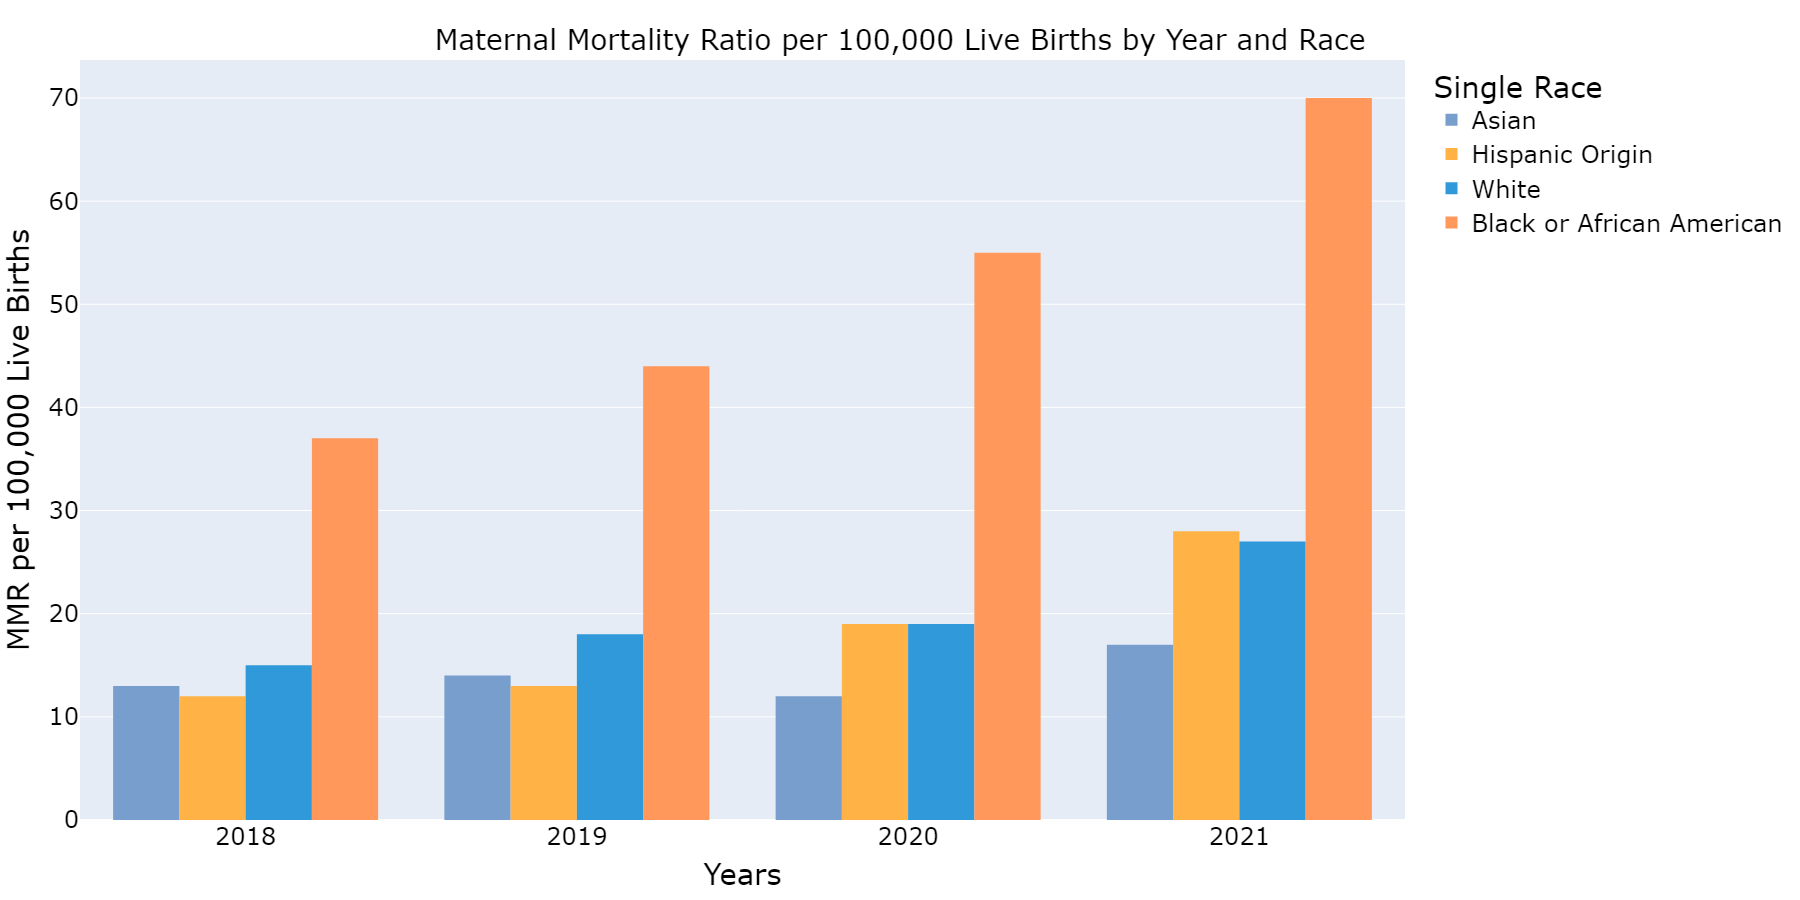

In [55]:
# use plotly's historgram function
# first argument is the datafram, then put your x and y axis
# colors the column name referencing the different bars in each group, if you want to group the bars by the x-axis, use group bar mode
# category_orders helps order the bars, I wanted ascending order
# 
fig = px.histogram(ratio_df, x="Year", y="MMR per 100,000 Live Births",
                   color='Single Race 6', barmode='group',
                   category_orders={"Single Race 6":["More than one race", "Asian", "Hispanic Origin", "White", "Black or African American"]},
                   color_discrete_sequence=["rgb(255, 152, 90)", "rgb(119, 158, 204)", "rgb(255, 179, 71)", "rgb(48, 153, 217)"],
                   labels={"Single Race 6": "Single Race"})
fig.update_layout(title={
                  'text':'Maternal Mortality Ratio per 100,000 Live Births by Year and Race',
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'x': 0.5},
                  yaxis_title={'text': 'MMR per 100,000 Live Births'},
                  xaxis_title={'text': 'Years'})
fig.update_layout(
    font_family="Verdana",
    font_color="black",
    font_size = 24,
    title_font_family="Verdana",
    title_font_color="black",
    title_font_size=28,
    legend_title_font_color="black"
)
fig.show(renderer='png', height=900, width=1800)